In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### python packages
import os
from os import path
import numpy as np
import glob as glob
from random import random
import pandas as pd

### torch packages
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import Sampler

### sklearn packages
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold


### remove these later (for notebook version only)
from tqdm import tqdm_notebook as tqdm
'''
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, export_png
from bokeh.layouts import row
output_notebook()
'''

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#newoutputvals=pickle.load(open('all_exonet_binary_CV_wfixedcent_dic.pickle','rb'))

In [3]:
newoutputvals={}
for n in range(8):
    print(n)
    #exonet_CV_6.8_101_all_Big_dic.pickle
    fpath='exonet_CV_'+str(n)+'.8_101_all_Big_tempdic.pickle'
    newoutputvals[fpath.replace('_tempdic.pickle','')]=pickle.load(open(fpath,'rb'))
    newoutputvals[fpath.replace('_tempdic.pickle','')]['k']=n

0
1
2
3
4
5
6
7


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
kcount=8
foldname='/home/hosborn/TESS/new_runs/exonet_multiclass_CV_wfixedcent'
savedicname='all_exonet_multiclass_CV_wfixedcent_dic'
models={'Big':'ExtranetModel'}
augment={'all':'all'}

mod='Big'
aug='all'
fpath='101'


print('#Assembling Cross-Val results after '+str(kcount)+' CVs')
dickeys=[key for key in newoutputvals if not np.isnan(float(newoutputvals[key]['k']))]

all_dics={}
arr_keys=['acc_val_epoch_unk', 'recall_val_epoch_pl', 'acc_val_epoch_ebs', 'ap_val_epoch',
          'ap_val_epoch_pl', 'acc_val_epoch_pl', 'acc_val_epoch_bebs', 'loss_train_epoch',
          'pred_val_final', 'recall_val_epoch_bebs', 'gt_val_final', 'recall_val_epoch_unk',
          'recall_val_epoch_ebs', 'loss_val_epoch']

#initialising:

for key in dickeys:
    for key2 in arr_keys:
        if type(newoutputvals[key][key2])==list and type(newoutputvals[key][key2][-1])==list:
            arr2dic=np.array(newoutputvals[key][key2][:-1])
        else:
            arr2dic=np.array(newoutputvals[key][key2])
        if len(np.shape(arr2dic))==2:
            if np.shape(arr2dic)[1]<=1:
                if key2 in all_dics:
                    all_dics[key2]=np.hstack((all_dics[key2].ravel(),arr2dic.ravel()))
                else:
                    all_dics[key2]=arr2dic.ravel()
            else:
                if key2 in all_dics:
                    all_dics[key2]=np.vstack((all_dics[key2],arr2dic))
                else:
                    all_dics[key2]=arr2dic
        elif len(np.shape(newoutputvals[key][key2]))==1:
            if key2 in all_dics:
                all_dics[key2]=np.hstack((all_dics[key2],arr2dic))
            else:
                all_dics[key2]=arr2dic

            

#Assembling Cross-Val results after 8 CVs


In [6]:
from exonet_basefile import *

In [7]:
one_hot_gt=make_one_hot(all_dics['gt_val_final'],4)

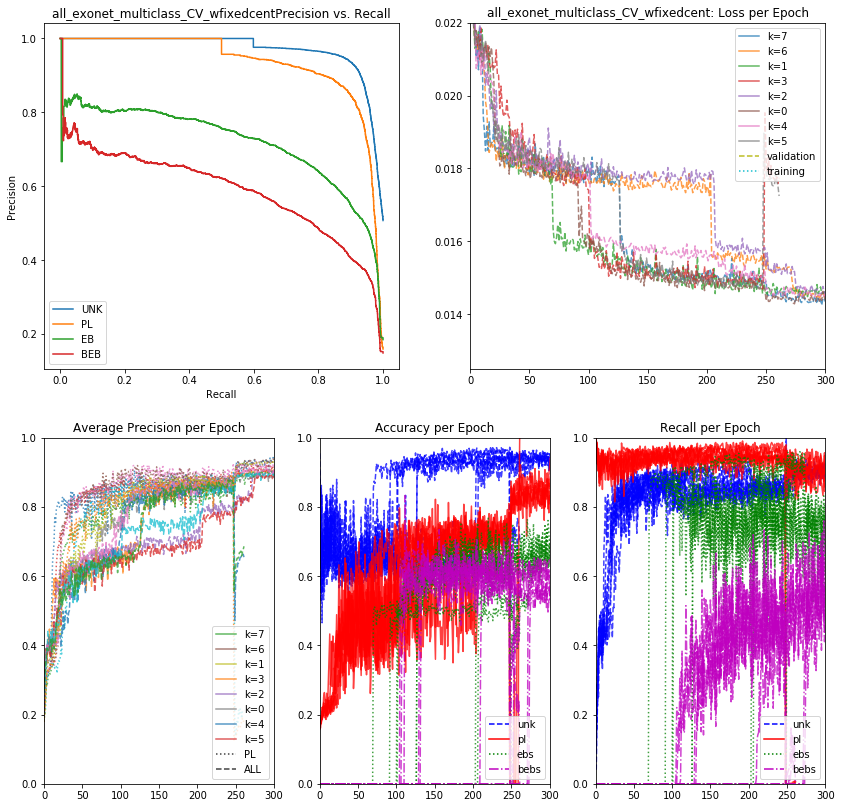

In [8]:
plt.figure(figsize=(14,14))

plt.clf()
plt.subplot(2,2,1)

labels=['UNK','PL','EB','BEB']
### plot values
for n in range(4):
    P, R, _ =precision_recall_curve(one_hot_gt[:,n],all_dics['pred_val_final'][:,n])
    plt.step(R, P,label=labels[n])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.title(savedicname.replace('_dic','')+'Precision vs. Recall')

plt.subplot(2,2,2)
plt.title(savedicname.replace('_dic','')+': Loss per Epoch')
#plt.plot(np.arange(len(loss_train_batch)), loss_train_batch,color=sns.color_palette()[0])
#plt.plot(np.arange(len(loss_val_batch)), loss_val_batch,color=sns.color_palette()[1])
for n,key in enumerate(dickeys):
    plt.plot(np.array(newoutputvals[key]['loss_train_epoch']),':',alpha=0.75,color=sns.color_palette()[n])
    plt.plot(np.array(newoutputvals[key]['loss_val_epoch']),'--',alpha=0.75,color=sns.color_palette()[n])
    plt.plot([0.0,0.0],[0.0,0.0],'-',alpha=0.75,label="k="+str(newoutputvals[key]['k']))
plt.plot([0.0,0.0],[0.0,0.0],'--',label='validation')
plt.plot([0.0,0.0],[0.0,0.0],':',label='training')
plt.legend(loc=1)
plt.ylim(0.0125,0.022)
plt.xlim(0.0,300)

plt.subplot(2,3,4)
plt.title('Average Precision per Epoch')
#plt.plot(np.arange(len(ap_val_epoch)), ap_val_epoch)
for key in dickeys:
    plt.plot(newoutputvals[key]['ap_val_epoch_pl'],':',alpha=0.75)
    plt.plot(newoutputvals[key]['ap_val_epoch'],'--',alpha=0.75)
    plt.plot([0.0,0.0],[0.0,0.0],'-',alpha=0.75,label="k="+str(newoutputvals[key]['k']))
plt.plot([0,0],[-1,-1],':k',alpha=0.75,label='PL')
plt.plot([0,0],[-1,-1],'--k',alpha=0.75,label='ALL')
plt.legend(loc=4)
plt.ylim(0.0,1.0)
plt.xlim(0.0,300)

plt.subplot(2,3,5)
plt.title('Accuracy per Epoch')
markers={'acc_val_epoch_unk':'--b','acc_val_epoch_pl':'-r','acc_val_epoch_ebs':':g','acc_val_epoch_bebs':'-.m'}
for key2 in ['acc_val_epoch_unk','acc_val_epoch_pl','acc_val_epoch_ebs','acc_val_epoch_bebs']:

    for key in dickeys:
        plt.plot(newoutputvals[key][key2],markers[key2],alpha=0.75)
        plt.plot([0.0,0.0],[0.0,0.0],markers[key2],alpha=0.75)
    plt.plot([0,0],[-1,-1],markers[key2],label=key2.split('_')[-1])
plt.legend(loc=4)
plt.ylim(0.0,1.0)
plt.xlim(0.0,300)

plt.subplot(2,3,6)
plt.title('Recall per Epoch')
markers={'recall_val_epoch_unk':'--b','recall_val_epoch_pl':'-r','recall_val_epoch_ebs':':g','recall_val_epoch_bebs':'-.m'}
for key2 in ['recall_val_epoch_unk','recall_val_epoch_pl','recall_val_epoch_ebs','recall_val_epoch_bebs']:
    for key in dickeys:
        plt.plot(newoutputvals[key][key2],markers[key2],alpha=0.75)
        plt.plot([0.0,0.0],[0.0,0.0],'-',alpha=0.75)
    plt.plot([0,0],[-1,-1],markers[key2],label=key2.split('_')[-1])
plt.legend(loc=4)
plt.ylim(0.0,1.0)
plt.xlim(0.0,300)

plt.savefig(path.join(foldname,savedicname.replace('_dic','_res2.png')))
pickle.dump(newoutputvals,open(path.join(foldname,savedicname+'_analysed.pickle'),'wb'))


In [12]:
import pickle
dic3=pickle.load(open('../exonet_multiclass_CV_wfixedcent/exonet_CV_3.8_101_all_Big_tempdic.pickle','rb'))
dic5=pickle.load(open('../exonet_multiclass_CV_wfixedcent/exonet_CV_5.8_101_all_Big_tempdic.pickle','rb'))
dic3here=pickle.load(open('exonet_CV_3.8_101_all_Big_tempdic.pickle','rb'))
dic5here=pickle.load(open('exonet_CV_5.8_101_all_Big_tempdic.pickle','rb'))

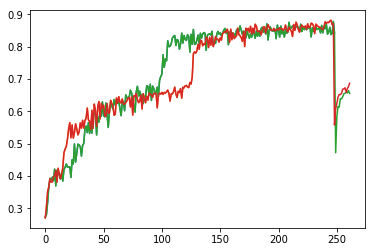

In [16]:
plt.plot(dic3['ap_val_epoch'])
plt.plot(dic5['ap_val_epoch'])
plt.plot(dic3here['ap_val_epoch'])
plt.plot(dic5here['ap_val_epoch'])

In [28]:
confmat=pd.DataFrame(confusion_matrix(all_dics['gt_val_final'],np.argmax(all_dics['pred_val_final'],axis=1)),index=['UNK','PL','EB','BEB'],columns=['UNK','PL','EB','BEB'])
confmat


,UNK,PL,EB,BEB
UNK,10748,865,326,227
PL,209,3546,18,13
EB,316,49,3335,651
BEB,383,156,1729,1328


In [32]:
labels=['UNK','PL','EB']
### plot values
for n in range(3):
    AP = average_precision_score(one_hot_gt[:,n], all_dics['pred_val_final'][:,n], average='weighted')
    print(labels[n],"average precision = {0:0.4f}".format(AP))
    

UNK average precision = 0.9446
PL average precision = 0.8878
EB average precision = 0.6542


In [30]:
print(np.sum(confmat.as_matrix(),axis=0))
print(np.sum(confmat.as_matrix(),axis=1))

[11656  4616  5408  2219]
[12166  3786  4351  3596]


/home/hosborn/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/home/hosborn/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [31]:
[np.sum(all_dics['gt_val_final']==n) for n in range(4)]

[12166, 3786, 4351, 3596]

In [22]:
## transform from loss per sample to loss per batch (multiple by batch size to compare to Chris')
#loss_train_batch = [x.item()* batch_size for x in loss_train_epoch]
#loss_val_batch = [x.item()* batch_size for x in loss_val_epoch]

### calculate average precision + precision-recall curves
P, R, _ = precision_recall_curve(gt_val_final, pred_val_final)
AP = average_precision_score(gt_val_final, pred_val_final, average='weighted')
print("average precision = {0:0.4f}".format(AP))

### convert prediction to bytes based on threshold
thresh = [0.9, 0.7, 0.5]
prec_thresh, recall_thresh = np.zeros(len(thresh)), np.zeros(len(thresh))
for n, nval in enumerate(thresh):
    pred_byte = np.zeros(len(pred_val_final))
    for i, val in enumerate(pred_val_final):
        if val > nval:
            pred_byte[i] = 1.0
        else:
            pred_byte[i] = 0.0
    prec_thresh[n] = precision_score(gt_val_final, pred_byte)
    recall_thresh[n] = recall_score(gt_val_final, pred_byte)
    print(n,": thresh = {0:0.2f}, precision = {1:0.2f}, recall = {2:0.2f}".format(thresh[n], prec_thresh[n], recall_thresh[n]))
    tn, fp, fn, tp = confusion_matrix(gt_val_final, pred_byte).ravel()
    print(n,":    TN = {0:0}, FP = {1:0}, FN = {2:0}, TP = {3:0}".format(tn, fp, fn, tp))
for key in dickeys:
    newoutputvals[key].update({'CV_P':P,'CV_R':R,'CV_AP':AP,'CV_matrix_0.5':[tn, fp, fn, tp]})

newoutputvals['exonet_CVall_'+fpath+'_'+aug+'_'+mod]={'loss_train_epoch':loss_train_epoch, 'loss_val_epoch':loss_val_epoch,
                              'acc_val_epoch':acc_val_epoch,'ap_val_epoch':ap_val_epoch,
                              'pred_val_final':pred_val_final, 'gt_val_final':gt_val_final,
                              'k':np.nan,'fpath':fpath,'aug':aug,'mod':mod,'unqid':fpath+'_'+aug+'_'+mod,
                              'P':P,'R':R,'AP':AP,'matrix_0.5':[tn, fp, fn, tp]}


NameError: name 'gt_val_final' is not defined

In [26]:
dickeys

['exonet_CV_1.8_101_all_Big',
 'exonet_CV_5.8_101_all_Big',
 'exonet_CV_3.8_101_all_Big',
 'exonet_CV_4.8_101_all_Big',
 'exonet_CV_2.8_101_all_Big',
 'exonet_CV_7.8_101_all_Big',
 'exonet_CV_6.8_101_all_Big']

In [11]:
key

'exonet_CVall_101_all_Big'

In [10]:
average_precision_score?

In [16]:
dickeys

[]